In [7]:
import utils
from astropy.io import fits
import astropy.units as u
from pathlib import Path
import subprocess
from IPython.display import clear_output, display
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

wavelength = 633e-9
fl = 425e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(1/pxscl_lamD)

zero = np.array([[0,0,0]]).T
v_bias = np.array([[50,50,50]]).T

pxscl_lamD * as_per_lamD


18.389524275269295 arcsec
10.982853643600734


<Quantity 1.6743849 arcsec>

/home/nicklambert/data/20250221_200/campupil
/home/nicklambert/data/20250221_200/fsm
/home/nicklambert/data/20250221_500/campupil
/home/nicklambert/data/20250221_500/fsm
/home/nicklambert/data/20250221_1000/campupil
/home/nicklambert/data/20250221_1000/fsm
/home/nicklambert/data/20250221_2000/campupil
/home/nicklambert/data/20250221_2000/fsm
44.478681385
0.07911881156065301
64422.47814758


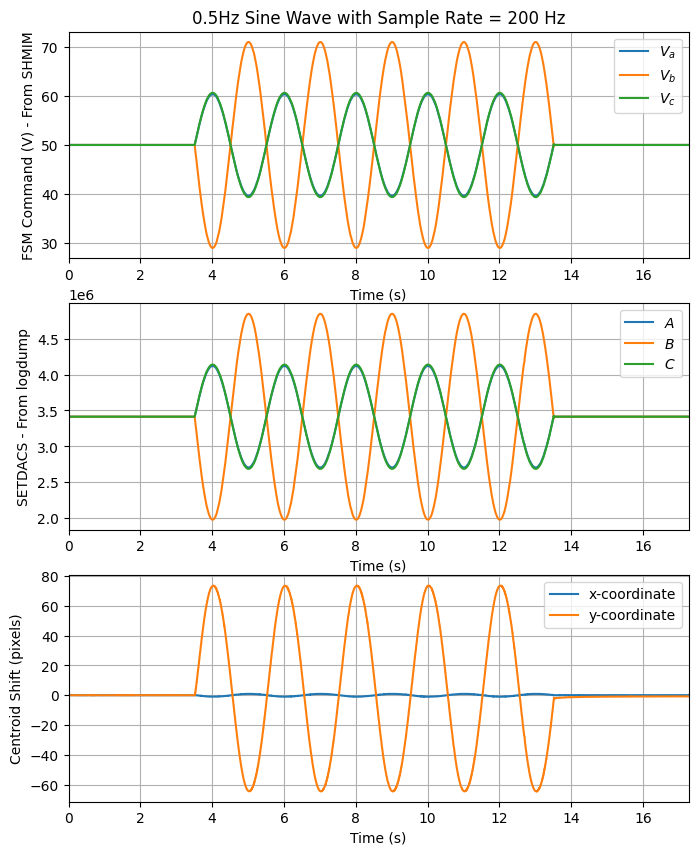

16.510746662
0.05018032049364203
64454.510693114


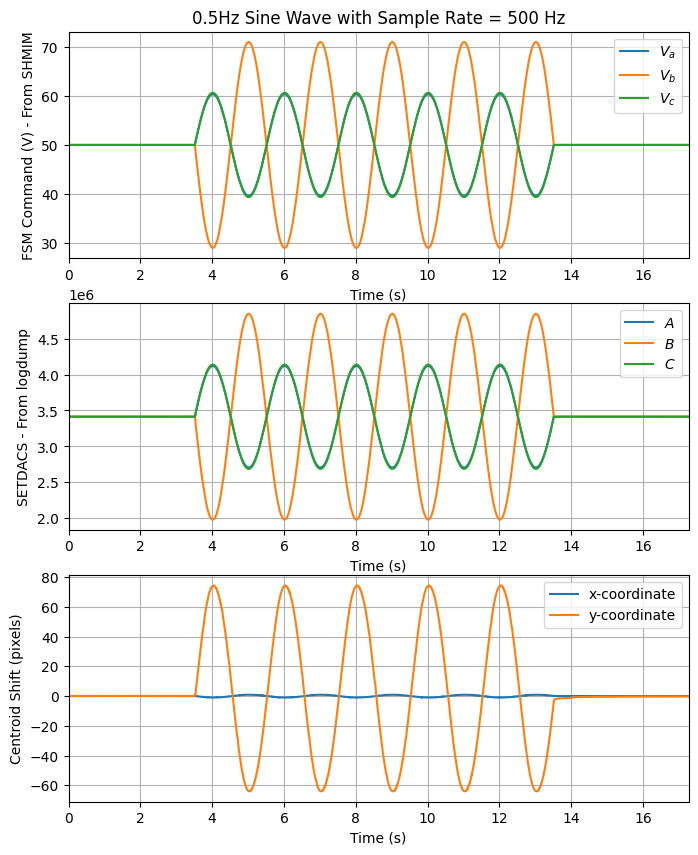

48.546689593
0.03319853924317916
64486.546719437


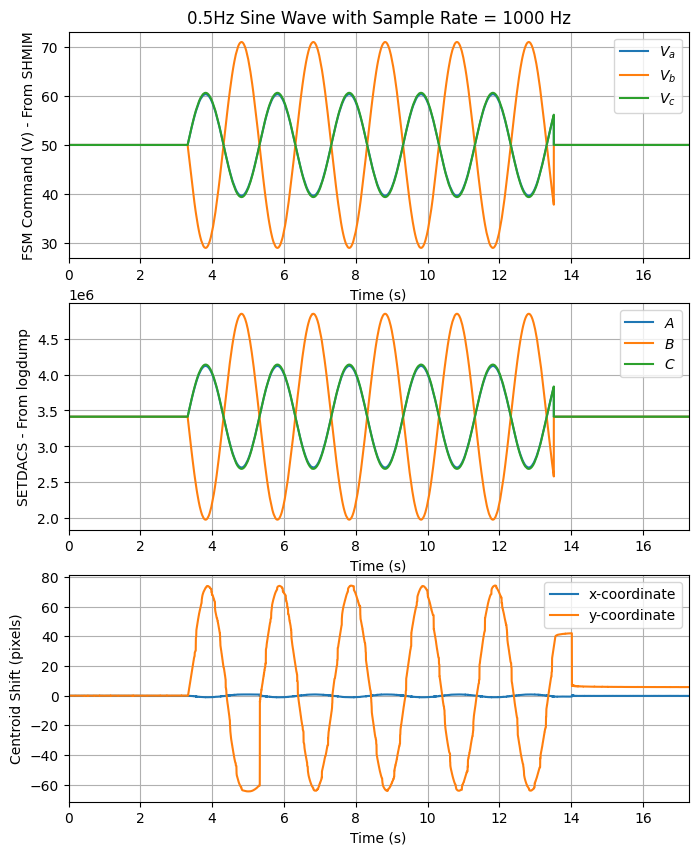

24.566751199
0.025002219768624954
64522.567409301


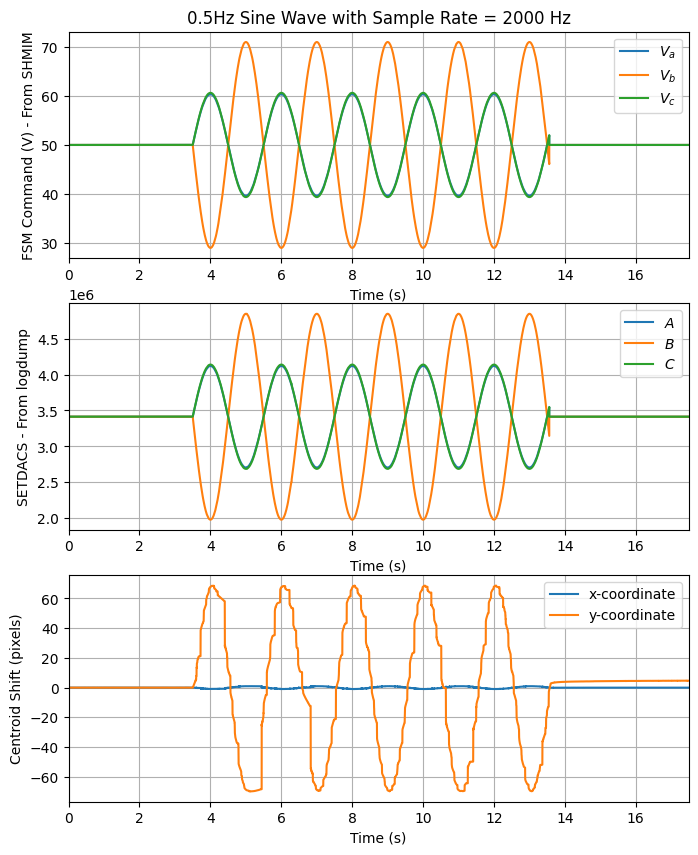

In [ ]:
# Decompress the .xrif files from the telem_* apps into the desired data directories
today = str('20250221')

freqs = np.array([200, 500, 1000, 2000]) # Hz
for freq in freqs:
    telem_cam_path = Path('/home/nicklambert/data/'+today+'_'+str(freq)+'/campupil/')
    telem_fsm_path = Path('/home/nicklambert/data/'+today+'_'+str(freq)+'/fsm/')
    
    
    if os.path.exists(Path(str(telem_cam_path)+'/fits/')) and os.path.isdir(Path(str(telem_cam_path)+'/fits/')):
        print(telem_cam_path)
    else:        
        subprocess.run(['xrif2fits','-d',str(telem_cam_path),'-D',str(telem_cam_path)+'/fits/'])
        clear_output()
        
    if os.path.exists(Path(str(telem_fsm_path)+'/fits/')) and os.path.isdir(Path(str(telem_fsm_path)+'/fits/')):
        print(telem_fsm_path)
    else:        
        subprocess.run(['xrif2fits','-d',str(telem_fsm_path),'-D',str(telem_fsm_path)+'/fits/'])
        clear_output()

for freq in freqs:
    telem_cam_path = Path('/home/nicklambert/data/'+today+'_'+str(freq)+'/campupil/')
    telem_fsm_path = Path('/home/nicklambert/data/'+today+'_'+str(freq)+'/fsm/')
    
    cam_data_fnames = sorted(glob.glob(str(telem_cam_path)+'/fits/*.fits'))
    fsm_data_fnames = sorted(glob.glob(str(telem_fsm_path)+'/fits/*.fits'))

    fsm_start_time = float(fsm_data_fnames[0].split("_")[-1][12:-5])/1e9
    print(fsm_start_time)
    fsm_commands = []
    fsm_times = []
    for fname in fsm_data_fnames:
        fsm_commands.append(fits.getdata(fname))
        #print(fits.getdata(fname))
        t_hr = float(fname.split("_")[-1][8:10])
        t_min = float(fname.split("_")[-1][10:12])
        t_sec = float(fname.split("_")[-1][12:-5])/1e9
        fsm_times.append( 3600*t_hr + 60*t_min + t_sec )
    fsm_commands = np.array(fsm_commands) 
    fsm_times = np.array(fsm_times)
    fsm_start = fsm_times[0]
    rel_fsm_times = fsm_times - fsm_start

    #print(fsm_start)
    #plt.plot(np.diff(rel_fsm_times[0:-1]))
    print(np.std(np.diff((rel_fsm_times[0:-1]))))
    frames = []
    cam_times = []
    for fname in cam_data_fnames:
        frames.append(fits.getdata(fname))
        t_hr = float(fname.split("_")[-1][8:10])
        t_min = float(fname.split("_")[-1][10:12])
        t_sec = float(fname.split("_")[-1][12:-5])/1e9
        cam_times.append( 3600*t_hr + 60*t_min + t_sec )
    frames = np.array(frames) 
    cam_times = np.array(cam_times)
    cam_start = cam_times[0]
    print(cam_start)
    rel_cam_times = cam_times - fsm_start
    #plt.plot(np.diff(rel_cam_times))
    cthresh = 0.2

    N = len(cam_data_fnames)
    #frame0 = utils.load_fits(str(exp_path/'campupil_0.fits'))
    #cen_0 = utils.centroid(frame0.astype(float), thresh=cthresh, plot=True)
    #mean_frame = np.mean(frames, axis=0)
    #imshow3(frame0, mean_frame, frames[0], lognorm=True)

    shift_pix = []
    total_shift_pix = []
    for i in range(N):
        if i==0:
            cen_0 = utils.centroid(frames[i].astype(float), thresh=cthresh, plot=0)
        cen = utils.centroid(frames[i].astype(float), thresh=cthresh, plot=0)
        shift = cen - cen_0
        shift_pix.append(shift)
        if shift[0]>0 and shift[1]>0:
            total_shift_pix.append(np.sqrt(shift[0]**2 + shift[1]**2))
        elif shift[0]>0 and shift[1]<0:
            total_shift_pix.append(np.sqrt(shift[0]**2 + shift[1]**2))
        elif shift[0]<0 and shift[1]>0:
            total_shift_pix.append(-np.sqrt(shift[0]**2 + shift[1]**2))
        elif shift[0]<0 and shift[1]<0:
            total_shift_pix.append(-np.sqrt(shift[0]**2 + shift[1]**2))
    shift_pix = np.array(shift_pix)
    total_shift_pix = np.array(total_shift_pix)

    shift_as = shift_pix * pxscl_lamD * as_per_lamD # pixels * (lamD/pixel) * (as/lamD)
    total_shift_as = total_shift_pix * pxscl_lamD * as_per_lamD

    # total_shift_pix = np.sqrt( np.sum( np.square(shift_pix), axis=1) )
    # total_shift_as = np.sqrt( np.sum( np.square(shift_as), axis=1) )

    

    logDumpFile = Path('/home/nicklambert/data/'+today+'_'+str(freq)+'/logdumpOut') 
    logDumpFileGrepped = Path('/home/nicklambert/data/'+today+'_'+str(freq)+'/logdumpOutGrepped') 
    os.system('cat '+str(logDumpFile)+' | grep SETDACS > '+str(logDumpFileGrepped))
    #f = open(logDumpFileGrepped,'x')
    #p = subprocess.Popen(['cat',logDumpFile,'|', 'grep','SETDACS'],stdout=f)
    with open(logDumpFileGrepped, 'r') as file:
        # Read all lines into a list
        lines = file.readlines()
    
    log_times = []
    dac1 = []
    dac2 = []
    dac3 = []
    # Process each line
    for line in lines:
        # Remove leading/trailing whitespace
        line = line.strip()

        # Skip empty lines
        if not line:
            continue

        # Split the line into parts (e.g., comma-separated values)
        parts = line.split(' ')
        #t = parse(parts[0])
        #print(str(t.hour*3600)+str(t.minute*60)+str(t.second)+str(t.microsecond*1e-6))
        t_hr = float(parts[0][11:13])
        t_min = float(parts[0][14:16])
        t_sec = float(parts[0][17:-1])
        log_times.append( 3600*t_hr + 60*t_min + t_sec )
        #print(parts[0])
        #print(str(t_hr)+' '+str(t_min)+' '+str(t_sec))
        dac3.append(int(parts[-1][0:7]))
        dac2.append(int(parts[-3][0:7]))
        dac1.append(int(parts[-5][0:7]))

    log_times = np.array(log_times)
    dac1 = np.array(dac1)
    dac2 = np.array(dac2)
    dac3 = np.array(dac3)
    log_times = log_times - fsm_start
    
    fig = plt.figure(figsize=(8,10))
    plt.subplot(311)
    plt.title('0.5Hz Sine Wave with Sample Rate = '+ str(freq)+ 'Hz')
    plt.plot(rel_fsm_times, fsm_commands[:,0], '-', label='$V_a$')
    plt.plot(rel_fsm_times, fsm_commands[:,1], '-', label='$V_b$')
    plt.plot(rel_fsm_times, fsm_commands[:,2], '-', label='$V_c$')
    plt.ylabel('FSM Command (V) - From SHMIM')
    plt.xlabel('Time (s)')
    plt.xlim([0,rel_fsm_times.max()])
    #plt.xlim([0, 10])
    plt.grid()
    plt.legend(loc='upper right')
    
    plt.subplot(312)
    plt.plot(log_times, dac1, '-', label='$A$')
    plt.plot(log_times, dac2, '-', label='$B$')
    plt.plot(log_times, dac3, '-', label='$C$')
    plt.ylabel('SETDACS - From logdump')
    plt.xlabel('Time (s)')
    plt.xlim([0,rel_fsm_times.max()])
    #plt.xlim([0,log_times.max()])
    #plt.xlim([0, 10])
    plt.grid()
    plt.legend(loc='upper right')
    
    plt.subplot(313)
    plt.plot(rel_cam_times, shift_pix[:,0], label='x-coordinate')
    plt.plot(rel_cam_times, shift_pix[:,1], label='y-coordinate')
    # plt.plot(rel_cam_times, total_shift_pix, label='total shift')
    #plt.plot(rel_cam_times, shift_as[:,0], label='x-coordinate')
    #plt.plot(rel_cam_times, shift_as[:,1], label='y-coordinate')
    #plt.plot(rel_cam_times, total_shift_as, label='total shift')
    plt.ylabel('Centroid Shift (pixels)')
    plt.xlabel('Time (s)')
    plt.xlim([0,rel_fsm_times.max()])
    #plt.xlim([0, rel_cam_times.max()])
    #plt.xlim([0, 10])
    plt.grid()
    plt.legend(loc='upper right')
    plt.show()
    
    
   